# Reading and evaluating PTB correlation data


In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import plotHistScales
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, pickle_copy, save_to_csv, save_to_excel, load_from_csv, load_from_excel, StatDataVector

import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, _CMF

out_dir = 'MCSim_Test'

import os
print( 'CWD:', os.getcwd())

CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend()
    return fig, ax1, ax2

# Demonstrate the availible correlation data in _CORR_PATH

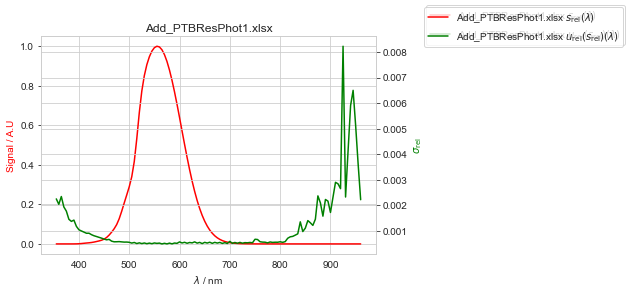

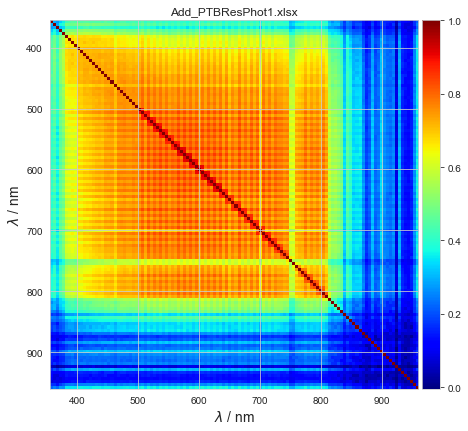

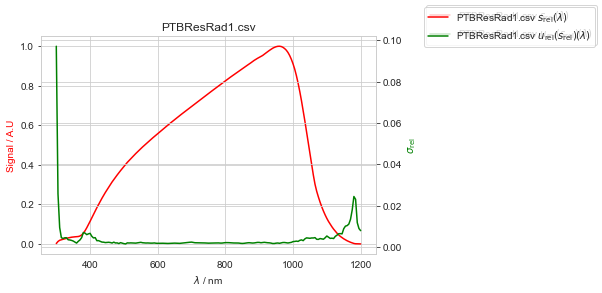

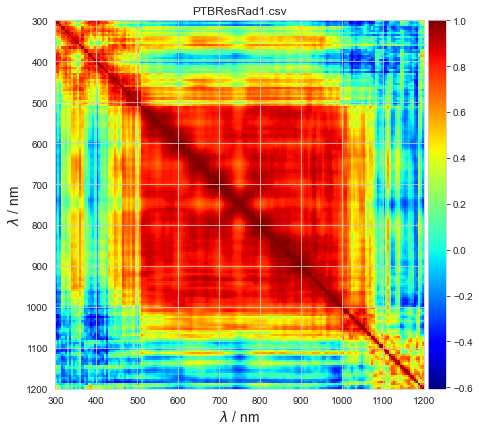

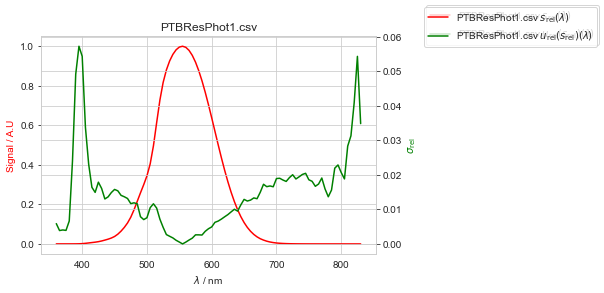

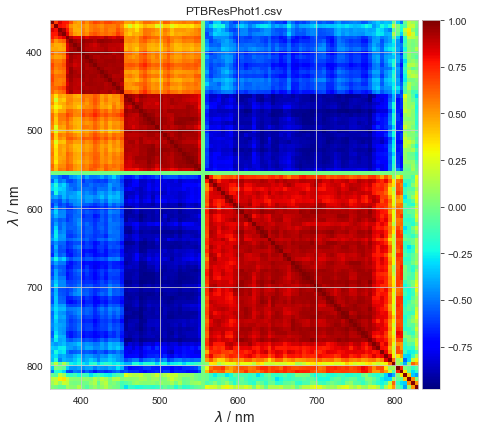

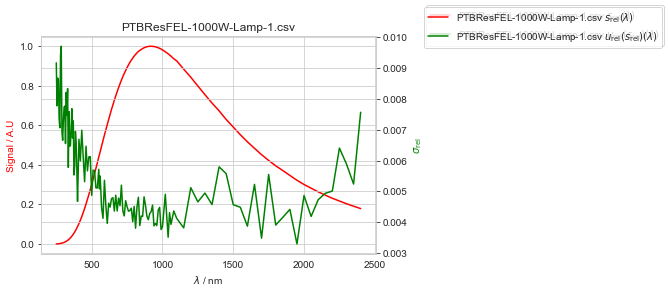

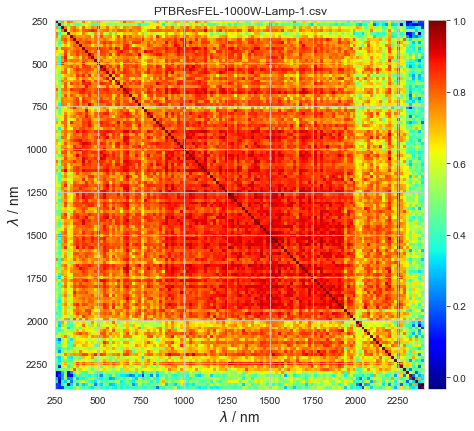

In [8]:
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from glob import glob

file_list = glob(_CORR_PATH + "*.*", recursive = False)
for file in file_list:
    if 'xls' in file:
        wl, mcVectorVar = load_from_excel(filename= file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
    else:
        wl, mcVectorVar = load_from_csv(filename= file)
    file_base = os.path.basename(file)
    fig, ax1, ax2 = plotMCResult(wl, mcVectorVar.setData, file_base)
    fig.legend(bbox_to_anchor=(1,1), loc="upper left")
    plotCorrelation(mcVectorVar.setData.corr_matrix, wl, file_base)



In [4]:
def get_data_dir( name):
    # handle the naming conventions of the data
    basic_path_in = 'G:/Data/MC'
    if 'Rad' in name:
        directory = basic_path_in + '/PTB/Radiometers/' + name + '/' + name + ' MC-results'
        out_dir_res = out_dir + '/Radiometer/' + name
    if 'Phot' in name:
        directory = basic_path_in + '/PTB/Photometers/' + name + '/' + name + ' MC-results'
        out_dir_res = out_dir + '/Photometer/' + name
    if 'FEL' in name:
        directory = basic_path_in + '/PTB/Lamps/' + name + '/MC-Data-' + name
        out_dir_res = out_dir + '/Lamps/' + name
    return directory, out_dir_res


In [ ]:
import fnmatch
import scipy
import copy

def conv(x):
    return x.replace(',', '.').encode()

# Prepare using all lists with names
Radiometerlist = ['Rad1', 'Rad2', 'Rad3', 'Rad4', 'Rad5']
Photometerlist = ['Phot1', 'Phot2', 'Phot3', 'Phot4', 'Phot5']
Photometerlist = ['Phot1']
Lamplist = ['FEL-1000W-Lamp-1','FEL-1000W-Lamp-2','FEL-1000W-Lamp-3','FEL-1000W-Lamp-4']
Lamplist = ['FEL-1000W-Lamp-1']

# Take one of the above lists to work with after the in statement
for rad in Photometerlist:
    directory, out_dir_res = get_data_dir(rad)

    # generate the result dir for the data
    os.makedirs(out_dir_res, exist_ok=True)

    print( 'Processing:', rad, ' from dir:', directory)
    print( 'Store results into:', out_dir_res)
    count = len(fnmatch.filter(os.listdir(directory), '*.txt')) + len(fnmatch.filter(os.listdir(directory), '*.dat'))
    print( 'Number of Runs:', count)
    spectrum = None
    bFirst = True

    # read all runs into the MMCVectorVar-class instance spectrum
    for i, filename in enumerate(os.scandir(directory)):
        if filename.is_file():
            data = np.loadtxt(filename).T
            if bFirst:
                spectrum = MCVectorVar( elements=data.shape[1])
                spectrum.allocate(trials=count)
                bFirst = False
            spectrum.val[i] = data[1]

    # evaluate the samples and generate the integral data (mean, std, cov, corr)
    spectrum.calc_cov_matrix_from_data()

    # read the integral information (mean, std, cov matrix) given in the dataset too
    cov_matrix_ptb = np.genfromtxt((conv(x) for x in open(directory + '/../' + rad + '-CovarianceMatrix.tsv')), delimiter='\t')
    print( 'Shape of the covariance matrix:', cov_matrix_ptb.shape)
    v_std_ptb, corr_matrix_ptb = MCVectorVar.calc_corr_matrix_static(cov_matrix_ptb)
    print( 'Shape of the corr matrix (generated from the cov matrix):', corr_matrix_ptb.shape)

    # The mean values are only available for Photometers and Radiometers only
    file_mean_data = directory + '/../' + rad + ' Calibdata.txt'
    trials = 100000
    if os.path.isfile(file_mean_data):
        # adjust the reading if required
        if 'Phot' in rad:
            skip = 7
        else:
            skip = 5
        data_mean = np.genfromtxt((conv(x) for x in open(file_mean_data)), delimiter='\t', skip_header=skip).T
        spectrumPTB = MCVectorVar( elements=data_mean.shape[1])
        spectrumPTB.set_vector_param(v_mean = data_mean[1], v_std=data_mean[2]/2, cov=cov_matrix_ptb)
    else:
        # the file with the mean value is not available --> take the mean from the runs
        data_mean = spectrum.val[0]
        spectrumPTB = MCVectorVar( elements=data_mean.shape[0])
        spectrumPTB.set_vector_param(v_mean = spectrum.runData.v_mean, v_std=spectrum.runData.v_std, cov=cov_matrix_ptb)
    # start with the integral data from PTB dataset and generate multivariate normal distributions (new runs)
    spectrumTT = pickle_copy(spectrumPTB)
    spectrumTT.generate_numbers(trials=trials)

    plotCorrelation(spectrumTT.runData.corr_matrix, data[0], rad + ' TTRuns')
    save_fig( out_dir_res,  filename='Corr_TTRuns' + rad)
    # only for chek (here are some problems with the wl of normalization, therefore compare the median filtered ones only
    plotCorrelation(spectrumTT.runData.corr_matrix - corr_matrix_ptb, data[0], rad + ' Diff (TTRuns-PTBRes)')
    #save_fig( out_dir_res,  filename='Corr_DiffTT' + rad)
    # filter due to the problem at the normalization point
    medFilter = scipy.ndimage.median_filter(spectrumTT.runData.corr_matrix - corr_matrix_ptb, size=3)
    plotCorrelation( medFilter, data[0], rad + ' Diff (TTRuns-PTBRes)m' + 't='+ str(trials))
    save_fig( out_dir_res,  filename='Corr_DiffTTm' + rad)

    plotCorrelation(corr_matrix_ptb, data[0], rad + ' PTBRes')
    save_fig( out_dir_res,  filename='Corr_PTBRes' + rad)

    plotCorrelation(spectrum.runData.corr_matrix, data[0], rad + ' PTBRuns')
    save_fig( out_dir_res,  filename='Corr_PTBRuns' + rad)

    plotCorrelation(spectrum.runData.corr_matrix - corr_matrix_ptb, data[0], rad + ' Diff (PTBRuns-PTBRes)')
    save_fig( out_dir_res,  filename='Corr_Diff' + rad)

    # plot the mean and stddev data for comparison
    fig, ax1, ax2 = plotMCResult(data[0], spectrum.runData, rad + 'PTBRuns')
    if spectrumPTB:
        plotMCResult(data[0], spectrumPTB.setData, rad + 'PTBRes', fig=fig, ax1=ax1, ax2=ax2, diagnumber=1)
    if spectrumTT:
        plotMCResult(data[0], spectrumTT.runData, rad + 'TTRuns', fig=fig, ax1=ax1, ax2=ax2, diagnumber=2)
    save_fig( out_dir_res,  filename='Mean_Runs' + rad)

    # writing all data to xls and csv for easy usage
    spectrum.calc_cov_matrix_from_data()
    save_to_excel(data[0], spectrum, filename=out_dir_res + '/' + 'PTBRuns' + rad)
    save_to_csv(data[0], spectrum, filename= out_dir_res + '/' + 'PTBRuns' + rad, sep=';')
    save_to_csv(data[0], spectrum, filename= out_dir_res + '/' + 'PTBRuns' + rad + '_de', sep=';', decimal=',')
    # check the reading of the saved data
    wl2, mcVectorVar2 = load_from_csv(filename= out_dir_res + '/' + 'PTBRuns' + rad, delimiter=';')
    plotCorrelation(mcVectorVar2.setData.corr_matrix, data[0], rad + ' Test Read setData')
    if spectrumPTB:
        save_to_excel(data[0], spectrumPTB, filename=out_dir_res + '/' + 'PTBRes' + rad,use_runData=False)
        save_to_csv(data[0], spectrumPTB, filename=out_dir_res + '/' + 'PTBRes' + rad, sep=';',use_runData=False)
        save_to_csv(data[0], spectrumPTB, filename=out_dir_res + '/' + 'PTBRes' + rad + '_de', sep=';', decimal=',', use_runData=False)

# Make some very first MCS

In [ ]:
# take the Photometer1
rad = 'Phot1'
FEL = 'FEL-1000W-Lamp-1'
NumberTrials = 1000

# get the source and dst information
directory, out_dir_res = get_data_dir(rad)
directoryFEL, out_dir_resFEL = get_data_dir(FEL)
# create a photometer (attention load_from_excel will not work at the moment due to problems with the cov matrix inversion)
# this defines the wl-Scale for the simulation
wl, mcVectorVarPhot = load_from_csv(out_dir_res + '/' + 'PTBRes' + rad + '_de')
wl, mcVectorVarPhot = load_from_excel(out_dir_res + '/' + 'PTBRes' + rad)
mcVectorVarPhot.generate_numbers(trials=NumberTrials)
plotCorrelation(mcVectorVarPhot.setData.corr_matrix, wl, rad + 'Set')
plotCorrelation(mcVectorVarPhot.runData.corr_matrix, wl, rad + 'Run')

wlFEL, mcVectorVarFEL = load_from_csv(out_dir_resFEL + '/' + 'PTBRes' + FEL)

#wlFEL, mcVectorVarFEL = load_from_excel(out_dir_resFEL + '/' + 'PTBRes' + FEL + '_res')
#plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, ' FEL Disturbed')
#mcVectorVarFEL.improve_covariance(mode='eigenvalues', ratio=0.001)
#plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, ' FEL eigenvalues 0.001')
#
#wlFEL, mcVectorVarFEL = load_from_excel(out_dir_resFEL + '/' + 'PTBRes' + FEL + '_res')
#mcVectorVarFEL.improve_covariance(mode='nearcorr')
#plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, ' FEL nearcorr')
#
#mcVectorVarFEL.generate_numbers(trials=NumberTrials)
#plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, FEL + 'Set')
#plotCorrelation(mcVectorVarFEL.runData.corr_matrix, wlFEL, FEL + 'Run')

wl2 = lx.getwlr([wlFEL[0], wlFEL[-1], 10])
# put the data at the same WL-Scale
mcVectorVarFEL.interpolate(wl, wlFEL, trials=NumberTrials)
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, FEL + 'Set-Interpolate')
plotCorrelation(mcVectorVarFEL.runData.corr_matrix, wl, FEL + 'Run-Interpolate')

v_std = np.ones_like(wl)*np.mean(mcVectorVarPhot.setData.v_std)
# for comparison, generate a fourier noise with the same mean stddev (a specific number of base functions)
mcVectorVarPhotF = MCVectorVar(elements=wl.shape[0], noise_list={ 'f_add': DistributionParam(mean=0, stddev=v_std[0], add_params=7)})

# the ideal detector is the VL-Detector
ideal_detector = _CMF['1931_2']['bar'][[0,2]].copy()
# at the right wavelength scale
ideal_detector = lx.cie_interp(ideal_detector, wl_new=wl, kind='S')
mcVectorVarPhotF.set_vector_param(v_mean=ideal_detector[1])

# for comparison, generate an ideal photometer without any noise
mcVectorVarPhotIdeal = MCVectorVar(elements=wl.shape[0])
mcVectorVarPhotIdeal.set_vector_param(v_mean=ideal_detector[1])


In [ ]:
# define some output data (as MCVar to make an analysis after the run)
mcL = MCVar(name=NameUnit('L', 'A.U.'))
mcYxy = MCVectorVar(name=NameUnit('Yxy', ''), elements=3)
mcXYZ = MCVectorVar(name=NameUnit('XYZ', ''), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
# define some basic data needed inside the MCS

# standard illuminant A
spectrumA = _CIE_ILLUMINANTS['A'].copy()
spectrumAInt = lx.cie_interp(spectrumA, wl_new=wl, kind='S')

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

# simple model calculating the photometric integral from the photometers
def model_L0( FEL):
    XYZ = lx.spd_to_xyz(np.vstack((wl, FEL)), relative=False)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    Yxy = lx.xyz_to_Yxy(XYZ)
    return [Yxy[0], XYZ[0], CCT, duv]

input = [mcVectorVarFEL]
output = [mcYxy, mcXYZ, mcCCT, mcDuv]

# prepare and run the MCS
sim = MCSimulation(trials=NumberTrials)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_L0)

# tell the results
for i in range(len(input)+1):
    print( i)
    for var in sim.output_var[i]:
        var.print_stat()

import pandas as pd
from empir19nrm02.tools import sumMC, sumMCV
var = sim.output_var[1]
cct = sim.output_var[1][2]
duv = sim.output_var[1][3]

res_data = None
colum_names = ['Input']
for i in range(len(input)+1):
    if i < len(input):
        if input[i].name:
            line_data = [input[i].name.name]
        else:
            line_data = ['Input#' + str(i)]
    else:
        line_data = ['All']

    for var in sim.output_var[i]:
        if isinstance(var, MCVectorVar):
            [values, interval] = sumMCV(var.val)
            for k in range(var.elements):
                line_data.append(values[0][k])
                line_data.append(values[1][k])
                if i == 0:
                    colum_names.append(var.name.name + '_' + str(k))
                    colum_names.append('u('+var.name.name + '_' + str(k)+')')
        else:
            [values, interval] = sumMC(var.val)
            line_data.append(values[0])
            line_data.append(values[1])
            if i == 0:
                colum_names.append(var.name.name)
                colum_names.append('u('+var.name.name+')')
    if res_data is None:
        res_data = pd.DataFrame( colum_names)
    res_data = pd.concat( [res_data, pd.DataFrame( line_data)], axis=1)

res_data = res_data.transpose()
res_data

In [ ]:
#display some histograms
var = sim.output_var[1]
plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title='Y' + rad, xLabel='$Y_{\mathrm{rel}}$')
save_fig(out_dir, 'HistYxy_Yrel')

In [ ]:
norm_data = pd.concat([pd.DataFrame(var[0].val[:,0]/np.mean(var[0].val[:,0])), pd.DataFrame(var[0].val[:,1]), pd.DataFrame(var[0].val[:,2]), pd.DataFrame(cct.val), pd.DataFrame(duv.val)], axis=1)
norm_data.columns = ['Y_rel', 'x', 'y', 'CCT', 'Duv']
print( norm_data.corr())
norm_dataXYZ = pd.concat([pd.DataFrame(var[1].val[:,0]),
                       pd.DataFrame(var[1].val[:,1]),
                       pd.DataFrame(var[1].val[:,2]),
                       pd.DataFrame(cct.val),
                       pd.DataFrame(duv.val),
                          ], axis=1)
norm_dataXYZ.columns = ['X', 'Y', 'Z', 'CCT', 'Duv']
print( norm_dataXYZ.corr())

In [ ]:
import seaborn as sns
def get_data_step(size_to_minimize, max_data_to_display=1000):
    if size_to_minimize < max_data_to_display:
        step = 1
        disp_count = size_to_minimize
    else:
        step = int(size_to_minimize / max_data_to_display)
        disp_count = int(size_to_minimize / step)
    return disp_count, step


In [ ]:
def seaborn_plot_result_gen(loc_result, display = [1,0,0], dim=3, column_str = [], title=''):
    disp_array_count, step = get_data_step(loc_result.shape[1])
    disp_array = np.zeros((dim, disp_array_count - 1))
    print( loc_result[:,0])
    for i in range(disp_array_count - 1):
        for j in range(dim):
            match display[j]:
                case 0 | 'n' | 'none':   disp_array[j, i] = loc_result[j, i * step + 1]
                case 1 | 'r' | 'rel':    disp_array[j, i] = loc_result[j, i * step + 1] / loc_result[j, 0]
                case 2 | 'd' | 'diff':   disp_array[j, i] = loc_result[j, i * step + 1] - loc_result[j, 0]
                case _: print('Display kind', display[j], ' not supported')

    sns.set_theme(style="ticks")
    for j in range(dim):
        match display[j]:
            case 0 | 'n' | 'none':   column_str[j] = '$'+ column_str[j] + '$'
            case 1 | 'r' | 'rel':    column_str[j] = '$'+ column_str[j] + '_{\mathrm{rel}}$'
            case 2 | 'd' | 'diff':   column_str[j] = '$'+ '\Delta ' + column_str[j] + '$'
            case _: print('Display kind', display[j], ' not supported')

    df = pd.DataFrame(data=disp_array.T, columns=column_str)
    grid = sns.pairplot(df, corner=True)
    plotTitle = title

    grid.fig.suptitle(plotTitle.format())

In [ ]:
seaborn_plot_result_gen(var[1].val.T, display = ['r', 'r', 'r'], dim=3, column_str=['X', 'Y', 'Z'], title='Observation_XYZ')
save_fig(out_dir, 'Observation_XYZ')

In [ ]:
seaborn_plot_result_gen(var[0].val.T, display = ['r', 'd', 'd'], dim=3, column_str=['Y', 'x', 'y'], title='Observation_Yxy')
save_fig(out_dir, 'Observation_Yxy')

In [ ]:
seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, duv.val.T)), display=['r','n','n','n','n'], dim=5, column_str=['Y', 'x', 'y', 'CCT', 'Duv'])
save_fig(out_dir, 'Observation_YxyCCTDuv')